In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt

import MicroTools as micro
from MicroTools import unfolder
import MiniTools as mini
import const
import param_scan

In [3]:
from importlib.resources import open_text
mode='fhc'
bar=''
MiniBooNE_Signal = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode",
            f"miniboone_numu{bar}nue{bar}fullosc_ntuple.txt",
        )
    )
nue_data = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode",
            f"miniboone_nue{bar}data_lowe.txt",
        )
    )
numu_data = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode",
            f"miniboone_numu{bar}data.txt",
        )
    )

nue_bkg = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode",
            f"miniboone_nue{bar}bgr_lowe.txt",
        )
    )
numu_MC = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode", f"miniboone_numu{bar}.txt"
        )
    )

fract_covariance = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.{mode}mode",
            f"miniboone_full_fractcovmatrix_nu{bar}_lowe.txt",
        )
    )

    # energy bins -- same for nu and nubar
bin_e = np.genfromtxt(
        open_text(
            f"MiniTools.include.MB_data_release_2020.combined",
            f"miniboone_binboundaries_nue_lowe.txt",
        )
    )
bin_widths = np.diff(bin_e)

In [4]:
# Load the MiniBooNE MC from data release
LMBT = 0.4685  # Baseline length in kilometers
Ereco = MiniBooNE_Signal[:, 0] # MeV
Etrue = MiniBooNE_Signal[:, 1] # MeV
Length = MiniBooNE_Signal[:, 2] / 100000  # Kilometers
Weight = MiniBooNE_Signal[:, 3] / len(MiniBooNE_Signal[:, 3])

Text(0, 0.5, '$E_\\nu$ (MeV)')

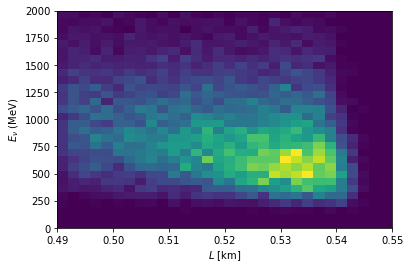

In [20]:
# _=plt.hist(Length, bins=50, weights=Weight, fc='orange')
# plt.xlabel('L [km]')
# plt.ylabel('Events')

plt.hist2d(Length, Etrue, bins=30, weights=Weight, range=((0.490, 0.550),(0,2e3)))
plt.xlabel(r'$L$ [km]')
plt.ylabel(r'$E_\nu$ (MeV)')

In [5]:
flux = np.genfromtxt('MiniTools/include/fluxes/MiniBooNE_FHC.dat')
enu = flux[:,0]*1e3 # MeV
F_nue = interpolate.interp1d(enu, flux[:,1], bounds_error=False, fill_value=0)
F_numu = interpolate.interp1d(enu, flux[:,2], bounds_error=False, fill_value=0)

In [6]:
def P(Enu, L, sin2thetaSQR=0.807, dmSQR=0.043):
    Enu = 1e-3 * Enu
    return sin2thetaSQR * np.sin(1.27*dmSQR * L/Enu)**2

In [7]:
import param_scan
theta={}
theta["g"] =0
theta["m4"] = np.sqrt(0.043)
theta["Ue4Sq"] = 1
theta["Um4Sq"] = 0.807/4

st = param_scan.Sterile(theta, oscillations=True, decay=False, decouple_decay=True)


In [8]:
import MiniTools as mini
mini.fit.chi2_MiniBooNE_2020(MC_numu_osc, 1, 1)

AttributeError: module 'MiniTools.fit' has no attribute 'chi2_MiniBooNE_2020'

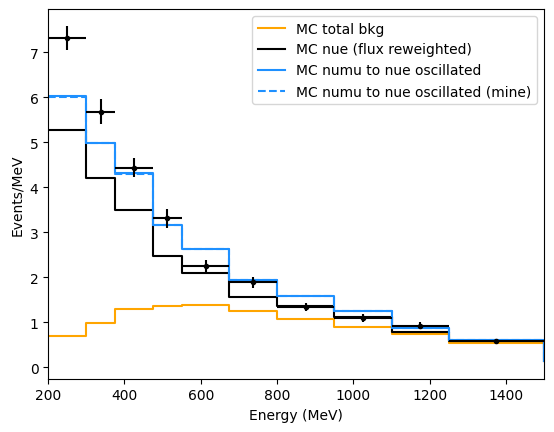

In [9]:
normalization = bin_widths

MC_numu_osc, _ = np.histogram(Ereco, weights=Weight*P(Etrue, Length, sin2thetaSQR=0.807, dmSQR=0.043), bins=bin_e, density=False)
MC_nue, _ = np.histogram(Ereco, weights=Weight*F_nue(Etrue)/F_numu(Etrue), bins=bin_e, density=False)
# 
MC_numu_osc_mine, _ = np.histogram(Ereco, weights=Weight*st.Pme(Etrue*1e-3, Etrue*1e-3, Length), bins=bin_e, density=False)
plt.step(bin_e[:-1], MC_nue/normalization, where='post', color='orange', label='MC total bkg')
BKG_counts, _ = np.histogram(bin_e[:-1], weights=nue_bkg, bins=bin_e, density=False)
plt.step(bin_e[:-1], BKG_counts/normalization, where='post', color='black', label='MC nue (flux reweighted)')

plt.step(bin_e[:-1], (MC_numu_osc+BKG_counts)/normalization, where='post', color='dodgerblue', label='MC numu to nue oscillated')
plt.step(bin_e[:-1], (MC_numu_osc_mine+BKG_counts)/normalization, where='post', color='dodgerblue', label='MC numu to nue oscillated (mine)', linestyle='--')

data_counts, _ = np.histogram(bin_e[:-1], weights=nue_data, bins=bin_e, density=False)
plt.errorbar(bin_e[:-1]+bin_widths/2, data_counts/normalization, xerr=bin_widths/2, yerr=np.sqrt(data_counts)/normalization, fmt='k.', ecolor='black')

plt.xlim(200,1500)
plt.ylabel('Events/MeV')
plt.xlabel('Energy (MeV)')
plt.legend()


<BarContainer object of 11 artists>

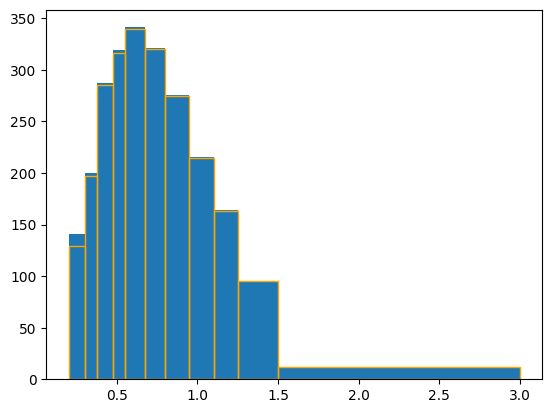

In [11]:
migration_matrix_unfolding_bins = param_scan.create_reco_migration_matrix(
    param_scan.MB_Ereco_unfold_bins
)  # 13 bins
migration_matrix_official_bins = param_scan.create_reco_migration_matrix(
    param_scan.MB_Ereco_official_bins
)  # 11 bins


# MBSig_for_unfolding = np.dot(
#         (np.histogram(Etrue*1e-3, bins=param_scan.e_prod_e_int_bins, weights=Weight)[0]),
#         migration_matrix_unfolding_bins,
#     )
# # plt.plot(MBSig_for_unfolding)
# plt.step(param_scan.MB_Ereco_unfold_bins[:-1], MBSig_for_unfolding, where='post')
bins = param_scan.MB_Ereco_official_bins
MBSig_for_fit = np.dot(
        (np.histogram(Etrue*1e-3, bins=param_scan.e_prod_e_int_bins, weights=Weight)[0]),
        migration_matrix_official_bins)
w = np.diff(bins)
x = bins[:-1] + w/2
plt.bar(x, MBSig_for_fit/w/1e3, w)

MC_numu_osc, _ = np.histogram(Ereco*1e-3, weights=Weight, bins=bins, density=False)
plt.bar(x, MC_numu_osc/w/1e3, w, facecolor='None', edgecolor='orange')
# plt.xlim(0.2,1.5)

<BarContainer object of 13 artists>

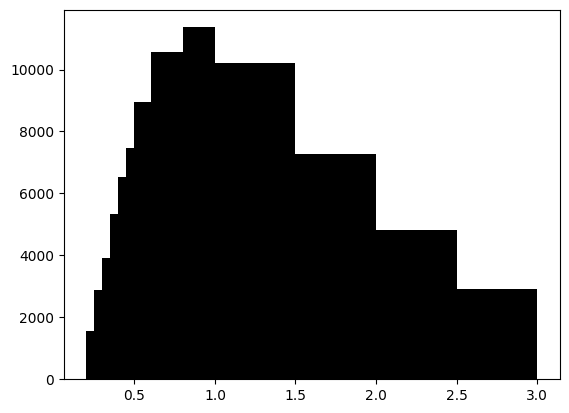

In [17]:
MCT = np.load(f"{micro.muB_inclusive_data_path}/MuB_NuE_True.npy")
MuB_True_BinEdges = [
    0.200,
    0.250,
    0.300,
    0.350,
    0.400,
    0.450,
    0.500,
    0.600,
    0.800,
    1.000,
    1.500,
    2.000,
    2.500,
    3.000,
]

de = np.diff(MuB_True_BinEdges)
ec = MuB_True_BinEdges[:-1]+de/2

plt.bar(ec, MCT/de, de, color='black')


In [131]:
from MicroTools import unfolder

GB = unfolder.MBtomuB(
    analysis="1eX",
    remove_high_energy=False,
    unfold=False,
    effNoUnfold=True,
    which_template="2020",
)

unf = unfolder.MBtomuB(
    analysis="1eX",
    remove_high_energy=False,
    unfold=True,
    effNoUnfold=True,
    which_template="2020",
)


In [133]:
np.shape(unf._migration)
len(MBSig_for_fit)

11

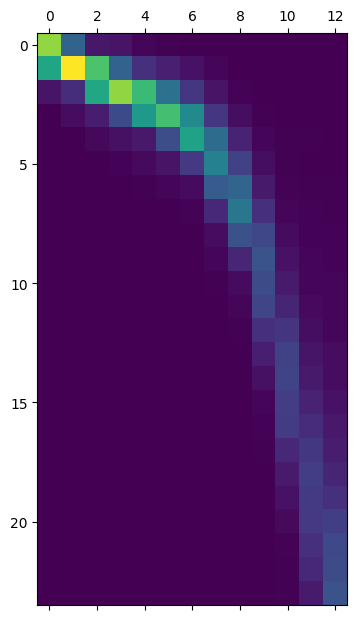

In [165]:
M =  np.loadtxt(
                f"{micro.path_unfolding_data}Migration_1eX.dat"
            )
plt.matshow(M)
# plt.plot(np.sum(M, axis=0))

1.0

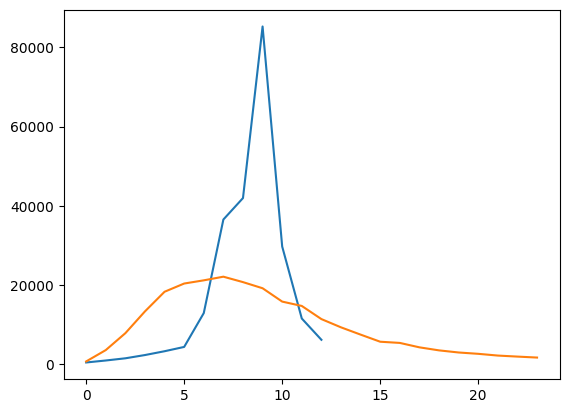

In [178]:
# plt.plot(GB.miniToMicro(MBSig_for_fit))
# plt.plot(unf.miniToMicro(MBSig_for_fit))
plt.plot(unf.miniToMicro(MBSig_for_fit))
plt.plot(np.matmul(M, unf.miniToMicro(MBSig_for_fit)))

unf.miniToMicro(MBSig_for_fit).sum() / (np.matmul(M, unf.miniToMicro(MBSig_for_fit))).sum()